<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Anomaly identification based on a convolutional autoencoder
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to identify anomalies, such as Earth surface deformations, in InSAR interferograms using machine learning.

Out goal here is to try to identify the surface deformation due to the earthquake from noises and processing errors using a neural network, more precisely a convolutional autoencoder.

# Package imports

In [1]:
%matplotlib notebook

import math
from glob import glob
from getpass import getpass
import matplotlib.pyplot as plt

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from skdaccess.utilities.srtm_util import merge_srtm_tiles

from pyinsar.processing.utilities.generic import sorted_alphanumeric
from pyinsar.data_import.import_raster import *
from pyinsar.data_import.import_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.processing.machine_learning.neural_networks.anomaly_identification import *
from pyinsar.processing.machine_learning.geostatistics.geostatistics_utils import standardize
from pyinsar.output.export_georaster import *
from pyinsar.output.plot_raster import *

/home/cerebro/local/miniconda/envs/python36-storm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import the data

In [2]:
base_folder = '/data/insar/mexico_case_studies/'

case_folder = '2018_Oaxaca_Earthquake/'
anomaly_index = 10

# case_folder = '2017_Puebla_Earthquake/'
# anomaly_index = 17

data_folder = base_folder + case_folder
anomaly_folder = data_folder + 'Anomaly_Identification/'
autoencoder_folder = anomaly_folder + 'Machine_Learning/'
training_folder = autoencoder_folder + 'Training_Data/'

training_data_names = ['Stacked_Referenced_filt_topophase_unw_geo']
# training_data_names = ['Stacked_Referenced_filt_atmtopophase_unw_geo']

application_data_names = [['Stacked_Referenced_filt_topophase_unw_geo'],
                          ['Stacked_Referenced_filt_atmtopophase_unw_geo']]

In [3]:
pads = (0, 0)

slices = [[0, None], [0, None]]
for i in range(len(pads)):
    if pads[i] > 0:
        slices[i][0] = pads[i]
        slices[i][1] = -pads[i]

Training data

In [4]:
training_data_paths = []
for training_data_name in training_data_names:
    training_data_path = glob(training_folder + '*Training_' + training_data_name + '*.tif')
    training_data_path = sorted_alphanumeric(training_data_path)
    training_data_paths.append(training_data_path)
training_data_paths = list(zip(*training_data_paths))

In [5]:
training_raster = open_georaster(training_data_paths[0][0])
subarray_shape = (training_raster.RasterYSize, training_raster.RasterYSize)

In [6]:
%%time

training_size = 0
for training_data_path in training_data_paths:
    training_raster = open_georaster(training_data_path[0])
    training_size += training_raster.RasterCount
    training_raster = None

training_data_array = np.empty((training_size, subarray_shape[0], subarray_shape[1], len(training_data_names)))
current_size = 0
for training_data_path in training_data_paths:
    for i, path in enumerate(training_data_path):
        training_raster = open_georaster(path)
        training_data_array[current_size:current_size + training_raster.RasterCount, ..., i] = get_georaster_array(training_raster)
        if i + 1 == len(training_data_path):
            current_size += training_raster.RasterCount
        training_raster = None

CPU times: user 1min 24s, sys: 3.44 s, total: 1min 28s
Wall time: 12.8 s


In [7]:
training_data_array.shape

(5880, 128, 128, 1)

<IPython.core.display.Javascript object>


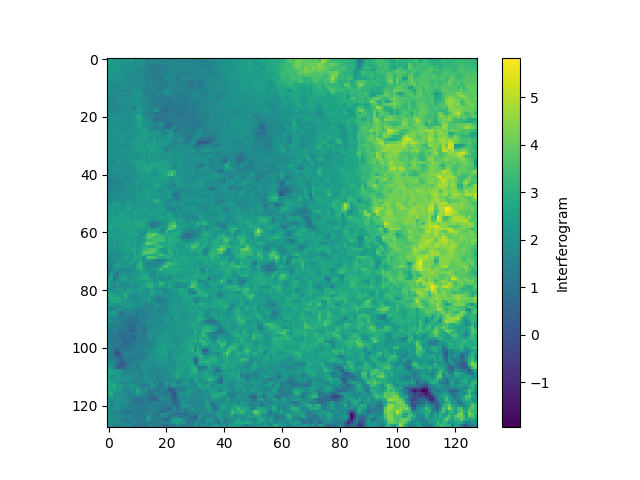

In [8]:
plot_interactive_multiple_slicing(training_data_array,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Interferogram')

Validation data

In [9]:
validation_data_paths = []
for validation_data_name in training_data_names:
    validation_data_path = glob(training_folder + '*Validation_' + validation_data_name + '*.tif')
    validation_data_path = sorted_alphanumeric(validation_data_path)
    validation_data_paths.append(validation_data_path)
validation_data_paths = list(zip(*validation_data_paths))

In [10]:
%%time

validation_size = 0
for validation_data_path in validation_data_paths:
    validation_raster = open_georaster(validation_data_path[0])
    validation_size += validation_raster.RasterCount
    validation_raster = None

validation_data_array = np.empty((validation_size, subarray_shape[0], subarray_shape[1], len(training_data_names)))
current_size = 0
for validation_data_path in validation_data_paths:
    for i, path in enumerate(validation_data_path):
        validation_raster = open_georaster(path)
        validation_data_array[current_size:current_size + validation_raster.RasterCount, ..., i] = get_georaster_array(validation_raster)
        if i + 1 == len(validation_data_path):
            current_size += validation_raster.RasterCount
        validation_raster = None

CPU times: user 33.9 s, sys: 1.1 s, total: 35 s
Wall time: 2.33 s


In [11]:
validation_data_array.shape

(713, 128, 128, 1)

<IPython.core.display.Javascript object>


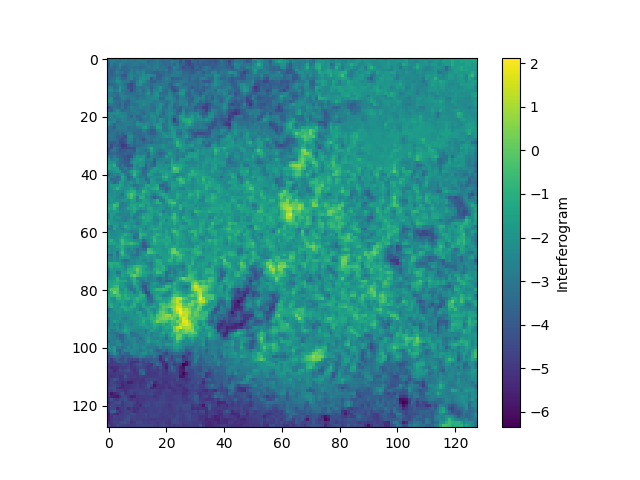

In [12]:
plot_interactive_multiple_slicing(validation_data_array,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Interferogram')

Test data

In [13]:
test_data_paths = []
for test_data_name in training_data_names:
    test_data_path = glob(training_folder + '*Test_' + test_data_name + '*.tif')
    test_data_path = sorted_alphanumeric(test_data_path)
    test_data_paths.append(test_data_path)
test_data_paths = list(zip(*test_data_paths))

In [14]:
%%time

test_size = 0
for test_data_path in test_data_paths:
    test_raster = open_georaster(test_data_path[0])
    test_size += test_raster.RasterCount
    test_raster = None

test_data_array = np.empty((test_size, subarray_shape[0], subarray_shape[1], len(training_data_names)))
current_size = 0
for test_data_path in test_data_paths:
    for i, path in enumerate(test_data_path):
        test_raster = open_georaster(path)
        test_data_array[current_size:current_size + test_raster.RasterCount, ..., i] = get_georaster_array(test_raster)
        if i + 1 == len(test_data_path):
            current_size += test_raster.RasterCount
        test_raster = None

CPU times: user 35.7 s, sys: 989 ms, total: 36.7 s
Wall time: 2.43 s


In [15]:
test_data_array[np.isnan(test_data_array)] = 0.

In [16]:
test_data_array.shape

(713, 128, 128, 1)

<IPython.core.display.Javascript object>


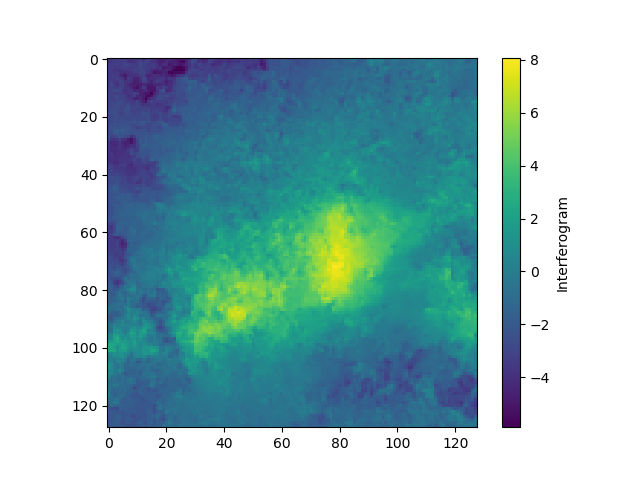

In [17]:
plot_interactive_multiple_slicing(test_data_array,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Interferogram')

Application case

In [18]:
%%time

georaster = open_georaster(data_folder + application_data_names[0][0] + '.tif')
application_data_array = get_georaster_array(georaster)[None]
application_data_extent = np.array(get_georaster_extent(georaster))
application_data_geotransform = georaster.GetGeoTransform()
application_data_projection = georaster.GetProjection()
application_data_spacing = (abs(georaster.GetGeoTransform()[5]), georaster.GetGeoTransform()[1])

for i in range(len(application_data_names)):
    for j in range(len(application_data_names[i])):
        if i != 0 or j != 0:
            georaster = open_georaster(data_folder + application_data_names[i][j] + '.tif')
            georaster_array = get_georaster_array(georaster)
            axis = 1
            if j == 0:
                axis = 0
            application_data_array = np.concatenate((application_data_array, georaster_array[None]), axis = axis)

application_data_array[:, :, np.isnan(application_data_array[0, 0])] = np.nan

CPU times: user 1min 21s, sys: 7.77 s, total: 1min 29s
Wall time: 52.1 s


<IPython.core.display.Javascript object>


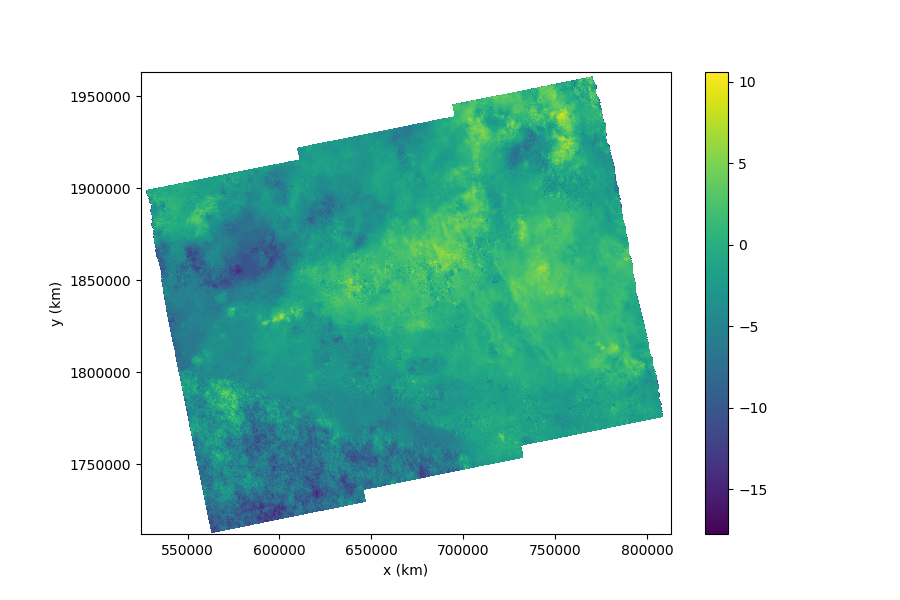

In [19]:
plot_interactive_multiple_slicing(application_data_array,
                                  [0, 1],
                                  [0, 0],
                                  update_colorbar = True,
                                  extent = application_data_extent,
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  figsize = (9, 6))

# Define the autoencoder, train, test, and apply

In [20]:
autoencoder_model = AutoencoderModel(autoencoder_folder + 'Training_Checkpoints/' + training_data_names[0], # Training_Checkpoints_Tests
                                     number_filters = 32,
                                     filter_shape = (3, 3),
                                     number_scaling = 3,
                                     resize_method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                                     normalization = None,
                                     regularization_scale = 0.1,
                                     number_channels = training_data_array.shape[-1],
                                     beta1 = 0.9,
                                     seed = 100)

Training

In [22]:
%%time

batch_size = 32

autoencoder_trainer = AutoencoderTrainer(autoencoder_model)
autoencoder_trainer.train(training_data_array,
                          validation_data_array,
                          number_epochs = 100,
                          batch_size = batch_size,
                          initial_learning_rate = 0.0001,
                          learning_transition_epoch = 50,
                          slices = slices,
                          do_restore = False,
                          summary_file_path = autoencoder_folder + 'Training_Summary',
                          print_step = 25,
                          validation_step = 250,
                          use_gpu = True)

Epoch: 1/100... Batch: 0/237... Training loss: 3.3900
Validation error: 3.238687971139727
Epoch: 1/100... Batch: 25/237... Training loss: 3.2457
Epoch: 1/100... Batch: 50/237... Training loss: 3.8280
Epoch: 1/100... Batch: 75/237... Training loss: 3.3988
Epoch: 1/100... Batch: 100/237... Training loss: 3.0592
Epoch: 1/100... Batch: 125/237... Training loss: 3.1868
Epoch: 1/100... Batch: 150/237... Training loss: 2.7758
Epoch: 1/100... Batch: 175/237... Training loss: 2.9504
Epoch: 1/100... Batch: 200/237... Training loss: 2.3818
Epoch: 1/100... Batch: 225/237... Training loss: 2.9499
Epoch: 2/100... Batch: 0/237... Training loss: 3.2605
Validation error: 2.3912363225892057
Epoch: 2/100... Batch: 25/237... Training loss: 2.7495
Epoch: 2/100... Batch: 50/237... Training loss: 2.1329
Epoch: 2/100... Batch: 75/237... Training loss: 2.3543
Epoch: 2/100... Batch: 100/237... Training loss: 2.9627
Epoch: 2/100... Batch: 125/237... Training loss: 1.7534
Epoch: 2/100... Batch: 150/237... Trainin

Epoch: 14/100... Batch: 200/237... Training loss: 0.7198
Epoch: 14/100... Batch: 225/237... Training loss: 0.9487
Epoch: 15/100... Batch: 0/237... Training loss: 0.9659
Validation error: 0.5254855093428079
Epoch: 15/100... Batch: 25/237... Training loss: 0.5140
Epoch: 15/100... Batch: 50/237... Training loss: 0.9329
Epoch: 15/100... Batch: 75/237... Training loss: 0.7205
Epoch: 15/100... Batch: 100/237... Training loss: 0.7697
Epoch: 15/100... Batch: 125/237... Training loss: 0.7525
Epoch: 15/100... Batch: 150/237... Training loss: 0.7937
Epoch: 15/100... Batch: 175/237... Training loss: 0.6117
Epoch: 15/100... Batch: 200/237... Training loss: 0.7626
Epoch: 15/100... Batch: 225/237... Training loss: 0.5483
Epoch: 16/100... Batch: 0/237... Training loss: 0.8445
Validation error: 0.47382571759381786
Epoch: 16/100... Batch: 25/237... Training loss: 0.6111
Epoch: 16/100... Batch: 50/237... Training loss: 0.6269
Epoch: 16/100... Batch: 75/237... Training loss: 0.6879
Epoch: 16/100... Batch:

Epoch: 28/100... Batch: 100/237... Training loss: 1.1788
Epoch: 28/100... Batch: 125/237... Training loss: 1.0980
Epoch: 28/100... Batch: 150/237... Training loss: 0.5030
Epoch: 28/100... Batch: 175/237... Training loss: 0.7718
Epoch: 28/100... Batch: 200/237... Training loss: 1.2451
Epoch: 28/100... Batch: 225/237... Training loss: 0.4989
Epoch: 29/100... Batch: 0/237... Training loss: 0.5816
Validation error: 0.3970185326093663
Epoch: 29/100... Batch: 25/237... Training loss: 0.8922
Epoch: 29/100... Batch: 50/237... Training loss: 0.7057
Epoch: 29/100... Batch: 75/237... Training loss: 0.8688
Epoch: 29/100... Batch: 100/237... Training loss: 0.4743
Epoch: 29/100... Batch: 125/237... Training loss: 0.5142
Epoch: 29/100... Batch: 150/237... Training loss: 1.5598
Epoch: 29/100... Batch: 175/237... Training loss: 0.7595
Epoch: 29/100... Batch: 200/237... Training loss: 0.6409
Epoch: 29/100... Batch: 225/237... Training loss: 0.5514
Epoch: 30/100... Batch: 0/237... Training loss: 0.8798
V

Validation error: 0.3450159740067557
Epoch: 42/100... Batch: 25/237... Training loss: 0.4144
Epoch: 42/100... Batch: 50/237... Training loss: 0.4442
Epoch: 42/100... Batch: 75/237... Training loss: 0.9201
Epoch: 42/100... Batch: 100/237... Training loss: 0.6939
Epoch: 42/100... Batch: 125/237... Training loss: 0.5494
Epoch: 42/100... Batch: 150/237... Training loss: 0.6744
Epoch: 42/100... Batch: 175/237... Training loss: 0.7548
Epoch: 42/100... Batch: 200/237... Training loss: 0.5426
Epoch: 42/100... Batch: 225/237... Training loss: 0.6755
Epoch: 43/100... Batch: 0/237... Training loss: 0.5574
Validation error: 0.3479150276604927
Epoch: 43/100... Batch: 25/237... Training loss: 0.7502
Epoch: 43/100... Batch: 50/237... Training loss: 0.5577
Epoch: 43/100... Batch: 75/237... Training loss: 0.5603
Epoch: 43/100... Batch: 100/237... Training loss: 0.4575
Epoch: 43/100... Batch: 125/237... Training loss: 0.8144
Epoch: 43/100... Batch: 150/237... Training loss: 0.5376
Epoch: 43/100... Batch

Epoch: 55/100... Batch: 175/237... Training loss: 0.4839
Epoch: 55/100... Batch: 200/237... Training loss: 0.7413
Epoch: 55/100... Batch: 225/237... Training loss: 0.6553
Epoch: 56/100... Batch: 0/237... Training loss: 0.4990
Validation error: 0.34250663939065396
Epoch: 56/100... Batch: 25/237... Training loss: 0.4195
Epoch: 56/100... Batch: 50/237... Training loss: 0.5586
Epoch: 56/100... Batch: 75/237... Training loss: 0.7181
Epoch: 56/100... Batch: 100/237... Training loss: 0.5768
Epoch: 56/100... Batch: 125/237... Training loss: 0.4633
Epoch: 56/100... Batch: 150/237... Training loss: 0.8481
Epoch: 56/100... Batch: 175/237... Training loss: 0.5253
Epoch: 56/100... Batch: 200/237... Training loss: 0.4744
Epoch: 56/100... Batch: 225/237... Training loss: 0.4222
Epoch: 57/100... Batch: 0/237... Training loss: 0.5631
Validation error: 0.3192237585649131
Epoch: 57/100... Batch: 25/237... Training loss: 0.4204
Epoch: 57/100... Batch: 50/237... Training loss: 0.5010
Epoch: 57/100... Batch

Epoch: 69/100... Batch: 75/237... Training loss: 1.0420
Epoch: 69/100... Batch: 100/237... Training loss: 0.4174
Epoch: 69/100... Batch: 125/237... Training loss: 0.8101
Epoch: 69/100... Batch: 150/237... Training loss: 0.8203
Epoch: 69/100... Batch: 175/237... Training loss: 0.4273
Epoch: 69/100... Batch: 200/237... Training loss: 0.6018
Epoch: 69/100... Batch: 225/237... Training loss: 0.4177
Epoch: 70/100... Batch: 0/237... Training loss: 0.4445
Validation error: 0.30038979842859326
Epoch: 70/100... Batch: 25/237... Training loss: 0.5918
Epoch: 70/100... Batch: 50/237... Training loss: 0.5149
Epoch: 70/100... Batch: 75/237... Training loss: 0.4555
Epoch: 70/100... Batch: 100/237... Training loss: 0.3859
Epoch: 70/100... Batch: 125/237... Training loss: 0.5208
Epoch: 70/100... Batch: 150/237... Training loss: 0.7944
Epoch: 70/100... Batch: 175/237... Training loss: 0.4726
Epoch: 70/100... Batch: 200/237... Training loss: 0.4088
Epoch: 70/100... Batch: 225/237... Training loss: 0.6234

Epoch: 83/100... Batch: 0/237... Training loss: 0.4818
Validation error: 0.28288888789049593
Epoch: 83/100... Batch: 25/237... Training loss: 0.7006
Epoch: 83/100... Batch: 50/237... Training loss: 0.3758
Epoch: 83/100... Batch: 75/237... Training loss: 0.5806
Epoch: 83/100... Batch: 100/237... Training loss: 0.4377
Epoch: 83/100... Batch: 125/237... Training loss: 0.6498
Epoch: 83/100... Batch: 150/237... Training loss: 0.6926
Epoch: 83/100... Batch: 175/237... Training loss: 0.7587
Epoch: 83/100... Batch: 200/237... Training loss: 0.7154
Epoch: 83/100... Batch: 225/237... Training loss: 0.4160
Epoch: 84/100... Batch: 0/237... Training loss: 0.5326
Validation error: 0.2904463299444085
Epoch: 84/100... Batch: 25/237... Training loss: 0.4164
Epoch: 84/100... Batch: 50/237... Training loss: 0.4568
Epoch: 84/100... Batch: 75/237... Training loss: 1.1277
Epoch: 84/100... Batch: 100/237... Training loss: 0.6700
Epoch: 84/100... Batch: 125/237... Training loss: 0.4514
Epoch: 84/100... Batch:

Epoch: 96/100... Batch: 150/237... Training loss: 0.4718
Epoch: 96/100... Batch: 175/237... Training loss: 0.4503
Epoch: 96/100... Batch: 200/237... Training loss: 0.6270
Epoch: 96/100... Batch: 225/237... Training loss: 0.4701
Epoch: 97/100... Batch: 0/237... Training loss: 0.3763
Validation error: 0.2745412417505814
Epoch: 97/100... Batch: 25/237... Training loss: 0.4965
Epoch: 97/100... Batch: 50/237... Training loss: 0.4513
Epoch: 97/100... Batch: 75/237... Training loss: 0.4525
Epoch: 97/100... Batch: 100/237... Training loss: 0.6732
Epoch: 97/100... Batch: 125/237... Training loss: 0.4587
Epoch: 97/100... Batch: 150/237... Training loss: 0.4104
Epoch: 97/100... Batch: 175/237... Training loss: 0.4996
Epoch: 97/100... Batch: 200/237... Training loss: 0.4974
Epoch: 97/100... Batch: 225/237... Training loss: 0.6480
Epoch: 98/100... Batch: 0/237... Training loss: 0.4607
Validation error: 0.2752832990318465
Epoch: 98/100... Batch: 25/237... Training loss: 0.4414
Epoch: 98/100... Batch

In [77]:
autoencoder_trainer.training_errors

[[6.8114867, 5.084302031105291],
 [5.8528085, 4.442086827919351],
 [2.9913049, 3.739511622826868],
 [3.6762693, 3.208999058528695],
 [2.2421381, 2.7713878494789874],
 [3.178739, 2.3860215174142825],
 [3.295677, 2.1559696798772117],
 [3.15003, 1.9028763283343397],
 [2.3783946, 1.7347867367541554],
 [2.6230097, 1.5978022293997827],
 [2.033842, 1.4925817577486267],
 [1.6038954, 1.3981302540722111],
 [1.9194224, 1.331568180525571],
 [1.7635901, 1.2854579958394774],
 [1.616417, 1.2240672559705432],
 [1.817657, 1.1524781143337486],
 [1.8615482, 1.147169176176974],
 [1.5243634, 1.0432991314519202],
 [1.6515725, 1.0230060588103322],
 [2.2378762, 1.0087911078714835],
 [1.5043237, 0.9670579707374733],
 [1.3325689, 0.9375154969335426],
 [1.8912239, 0.9111835144527735],
 [1.7473617, 0.8955369014254003],
 [1.3124337, 0.844753859484266],
 [1.6864059, 0.9283942793550316],
 [1.7085774, 0.8452512706120123],
 [1.5238659, 0.8186306745543432],
 [1.8003564, 0.8393223097449315],
 [1.5826886, 0.7804347050406

Testing

In [21]:
%%time

autoencoder_predictor = AutoencoderPredictor(autoencoder_model)
test_predictions = autoencoder_predictor.batch_predict(test_data_array, batch_size = 50)

INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch: 0/713...
Batch: 50/713...
Batch: 100/713...
Batch: 150/713...
Batch: 200/713...
Batch: 250/713...
Batch: 300/713...
Batch: 350/713...
Batch: 400/713...
Batch: 450/713...
Batch: 500/713...
Batch: 550/713...
Batch: 600/713...
Batch: 650/713...
Batch: 700/713...
CPU times: user 1min 55s, sys: 35.4 s, total: 2min 31s
Wall time: 7.51 s


In [22]:
%%time

# test_anomaly_score = np.abs(test_predictions[:,
#                                              slices[0][0]:slices[0][1],
#                                              slices[1][0]:slices[1][1]] - standardize(test_data_array[:,
#                                                                                           slices[0][0]:slices[0][1],
#                                                                                           slices[1][0]:slices[1][1]], axis = (1, 2)))
test_anomaly_score = np.abs(test_predictions[:,
                                             slices[0][0]:slices[0][1],
                                             slices[1][0]:slices[1][1]] - test_data_array[:,
                                                                                          slices[0][0]:slices[0][1],
                                                                                          slices[1][0]:slices[1][1]])

CPU times: user 241 ms, sys: 84 ms, total: 325 ms
Wall time: 22 ms


<IPython.core.display.Javascript object>


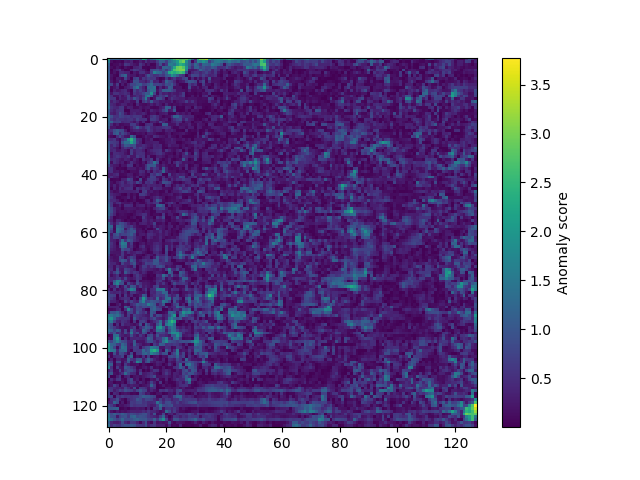

In [23]:
plot_interactive_multiple_slicing(test_anomaly_score,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Anomaly score')

In [24]:
test_anomaly_median = np.median(test_anomaly_score, axis = (1, 2, 3))

In [25]:
test_p90 = np.percentile(test_anomaly_median, 90)
test_p99 = np.percentile(test_anomaly_median, 99)
test_max = np.max(test_anomaly_median)

print('Min:', np.min(test_anomaly_median))
print('Median:', np.median(test_anomaly_median))
print('Mean:', np.mean(test_anomaly_median))
print('P90:', test_p90)
print('P99:', test_p99)
print('Max:', test_max)

Min: 0.04400131497040438
Median: 0.18024287650296245
Mean: 0.4081257205330949
P90: 0.5981149439263259
P99: 5.973956856692321
Max: 8.133879943256051


<IPython.core.display.Javascript object>


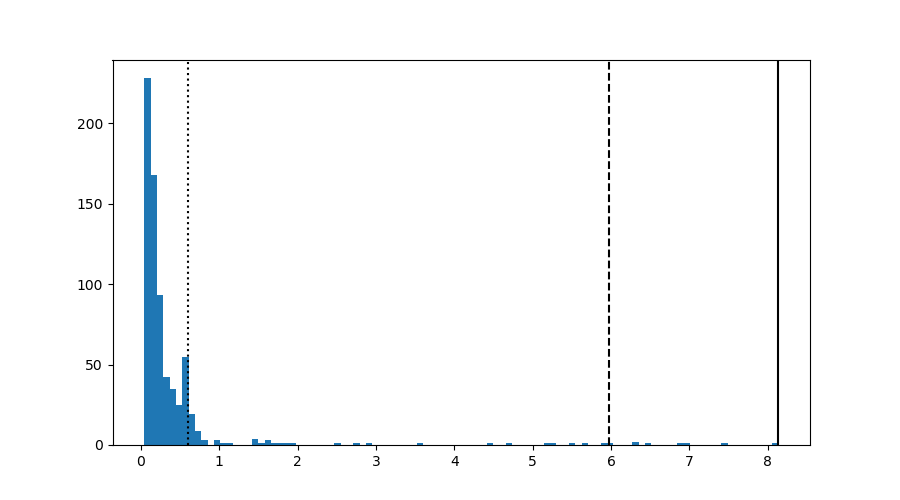

In [26]:
figure, subplot = plt.subplots(figsize = (9, 5))

plt.hist(test_anomaly_median, bins = 100)

plt.axvline(x = test_p90, c = 'black', linestyle = 'dotted')
plt.axvline(x = test_p99, c = 'black', linestyle = 'dashed')
plt.axvline(x = test_max, c = 'black', linestyle = 'solid')
                
plt.show()

Application by predicting tiles

In [27]:
%%time

index = 0

tile_shape = subarray_shape
steps = subarray_shape
is_shape_centered = False
return_subarray_indexes = True

tiles, tile_indices = sample_array(application_data_array[index],
                                   tile_shape,
                                   steps = steps,
                                   pads = pads,
                                   is_shape_centered = is_shape_centered,
                                   return_subarray_indexes = return_subarray_indexes)
tiles = np.moveaxis(tiles, 1, -1)

CPU times: user 1.52 s, sys: 461 ms, total: 1.98 s
Wall time: 1.98 s


In [28]:
tiles.shape

(317, 128, 128, 24)

In [29]:
%%time

autoencoder_decisions = []
tiled_anomaly_scores = []

for i in range(tiles.shape[-1]):
    
    autoencoder_predictor = AutoencoderPredictor(autoencoder_model)
    tile_predictions = autoencoder_predictor.batch_predict(tiles[..., i:i + 1], batch_size = 10)
    
    autoencoder_decisions.append(np.median(np.abs(tile_predictions[:, slices[0][0]:slices[0][1], slices[1][0]:slices[1][1], 0]
                                                  - tiles[:, slices[0][0]:slices[0][1], slices[1][0]:slices[1][1], i]), axis = (1, 2)))
    
    tiled_anomaly_score = np.full(application_data_array.shape[-2:], np.nan)
    for j, tile_indice in enumerate(tile_indices):
        tiled_anomaly_score[tile_indice[0]:tile_indice[0] + tile_shape[0],
                            tile_indice[1]:tile_indice[1] + tile_shape[1]] = np.abs(tile_predictions[j, slices[0][0]:slices[0][1], slices[1][0]:slices[1][1], 0] 
                                                                                    - tiles[j, slices[0][0]:slices[0][1], slices[1][0]:slices[1][1], i])
    tiled_anomaly_scores.append(tiled_anomaly_score)

INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch: 0/317...
Batch: 10/317...
Batch: 20/317...
Batch: 30/317...
Batch: 40/317...
Batch: 50/317...
Batch: 60/317...
Batch: 70/317...
Batch: 80/317...
Batch: 90/317...
Batch: 100/317...
Batch: 110/317...
Batch: 120/317...
Batch: 130/317...
Batch: 140/317...
Batch: 150/317...
Batch: 160/317...
Batch: 170/317...
Batch: 180/317...
Batch: 190/317...
Batch: 200/317...
Batch: 210/317...
Batch: 220/317...
Batch: 230/317...
Batch: 240/317...
Batch: 250/317...
Batch: 260/317...
Batch: 270/317...
Batch: 280/317...
Batch: 290/317...
Batch: 300/317...
Batch: 310/317...
INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch

Batch: 110/317...
Batch: 120/317...
Batch: 130/317...
Batch: 140/317...
Batch: 150/317...
Batch: 160/317...
Batch: 170/317...
Batch: 180/317...
Batch: 190/317...
Batch: 200/317...
Batch: 210/317...
Batch: 220/317...
Batch: 230/317...
Batch: 240/317...
Batch: 250/317...
Batch: 260/317...
Batch: 270/317...
Batch: 280/317...
Batch: 290/317...
Batch: 300/317...
Batch: 310/317...
INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch: 0/317...
Batch: 10/317...
Batch: 20/317...
Batch: 30/317...
Batch: 40/317...
Batch: 50/317...
Batch: 60/317...
Batch: 70/317...
Batch: 80/317...
Batch: 90/317...
Batch: 100/317...
Batch: 110/317...
Batch: 120/317...
Batch: 130/317...
Batch: 140/317...
Batch: 150/317...
Batch: 160/317...
Batch: 170/317...
Batch: 180/317...
Batch: 190/317...
Batch: 200/317...
Batch: 210/317...
Batch: 220/317...
Batc

Batch: 0/317...
Batch: 10/317...
Batch: 20/317...
Batch: 30/317...
Batch: 40/317...
Batch: 50/317...
Batch: 60/317...
Batch: 70/317...
Batch: 80/317...
Batch: 90/317...
Batch: 100/317...
Batch: 110/317...
Batch: 120/317...
Batch: 130/317...
Batch: 140/317...
Batch: 150/317...
Batch: 160/317...
Batch: 170/317...
Batch: 180/317...
Batch: 190/317...
Batch: 200/317...
Batch: 210/317...
Batch: 220/317...
Batch: 230/317...
Batch: 240/317...
Batch: 250/317...
Batch: 260/317...
Batch: 270/317...
Batch: 280/317...
Batch: 290/317...
Batch: 300/317...
Batch: 310/317...
INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch: 0/317...
Batch: 10/317...
Batch: 20/317...
Batch: 30/317...
Batch: 40/317...
Batch: 50/317...
Batch: 60/317...
Batch: 70/317...
Batch: 80/317...
Batch: 90/317...
Batch: 100/317...
Batch: 110/317...
Batch: 120/317.

In [30]:
autoencoder_decisions = np.array(autoencoder_decisions)
tiled_anomaly_scores = np.array(tiled_anomaly_scores)

tile_indices = np.array(tile_indices, dtype = np.float)
tile_indices[:, 0] += steps[0]/2.
tile_indices[:, 1] += steps[1]/2.

In [31]:
autoencoder_decisions.shape

(24, 317)

<IPython.core.display.Javascript object>


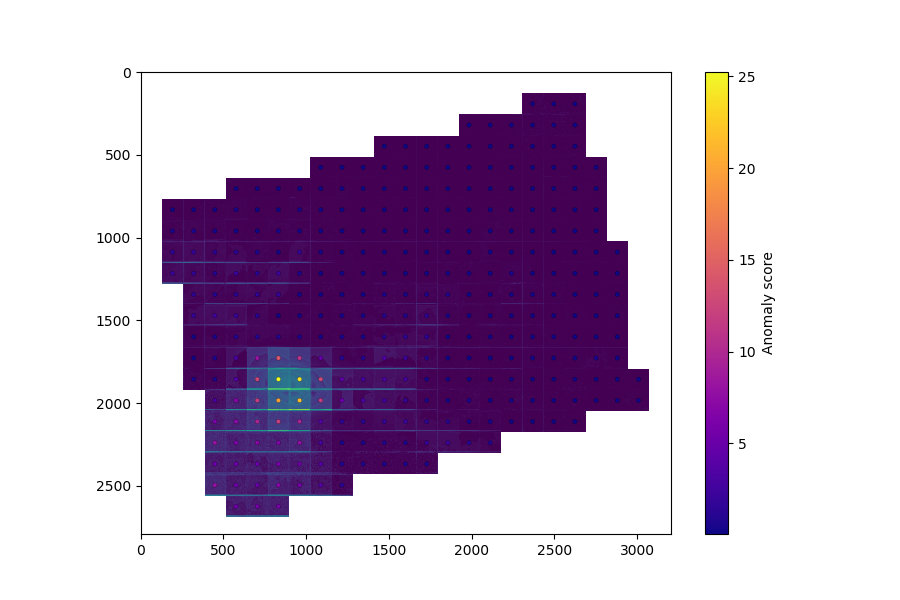

In [32]:
i_image = 10

figure, subplot = plt.subplots(figsize = (9, 6))

raster_map = plt.imshow(np.ma.masked_invalid(tiled_anomaly_scores[i_image]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

scatter = plt.scatter(tile_indices[:, 1],
                      tile_indices[:, 0],
                      c = autoencoder_decisions[i_image],
                      s = 10, cmap = 'plasma',
                      linewidth = 0.15, edgecolor = 'black')

raster_map_colorbar = plt.colorbar(scatter)
raster_map_colorbar.set_label('Anomaly score')
                
plt.show()

In [27]:
suffix = 'topophase'
# suffix = 'atmtopophase'
for i in range(autoencoder_decisions.shape[0]):
    np.savetxt(anomaly_folder + 'tile_anomaly_score_training_' + suffix + '_prediction_' + suffix + '_pair' + str(i + 1) + '_autoencoder.csv',
               (tile_indices[:, 1], tile_indices[:, 0], autoencoder_decisions[i]))

In [28]:
georaster = create_georaster_from_array(tiled_anomaly_scores,           
                                        application_data_geotransform, 
                                        application_data_projection,
                                        file_type = 'GTiff',
                                        file_path = anomaly_folder + 'Stacked_Referenced_tiled_cae_anomaly_score_training_' + suffix + '_prediction_' + suffix + '.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None

Application by predicting directly the entire interferogram

In [33]:
%%time

index = 0

tf_application_data_array = np.copy(application_data_array[index])
tf_application_data_array[np.isnan(tf_application_data_array)] = 0.
autoencoder_predictor = AutoencoderPredictor(autoencoder_model)
prediction = autoencoder_predictor.batch_predict(tf_application_data_array[..., None])
prediction[:, np.isnan(application_data_array[0, 0]), :] = np.nan

INFO:tensorflow:Restoring parameters from /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Anomaly_Identification/Machine_Learning/Training_Checkpoints/Stacked_Referenced_filt_topophase_unw_geo/autoencoder-99
Batch: 0/24...
Batch: 1/24...
Batch: 2/24...
Batch: 3/24...
Batch: 4/24...
Batch: 5/24...
Batch: 6/24...
Batch: 7/24...
Batch: 8/24...
Batch: 9/24...
Batch: 10/24...
Batch: 11/24...
Batch: 12/24...
Batch: 13/24...
Batch: 14/24...
Batch: 15/24...
Batch: 16/24...
Batch: 17/24...
Batch: 18/24...
Batch: 19/24...
Batch: 20/24...
Batch: 21/24...
Batch: 22/24...
Batch: 23/24...
CPU times: user 32min 59s, sys: 8min 18s, total: 41min 17s
Wall time: 1min 31s


In [34]:
anomaly_scores = np.abs(prediction[..., 0] - tf_application_data_array)

<IPython.core.display.Javascript object>


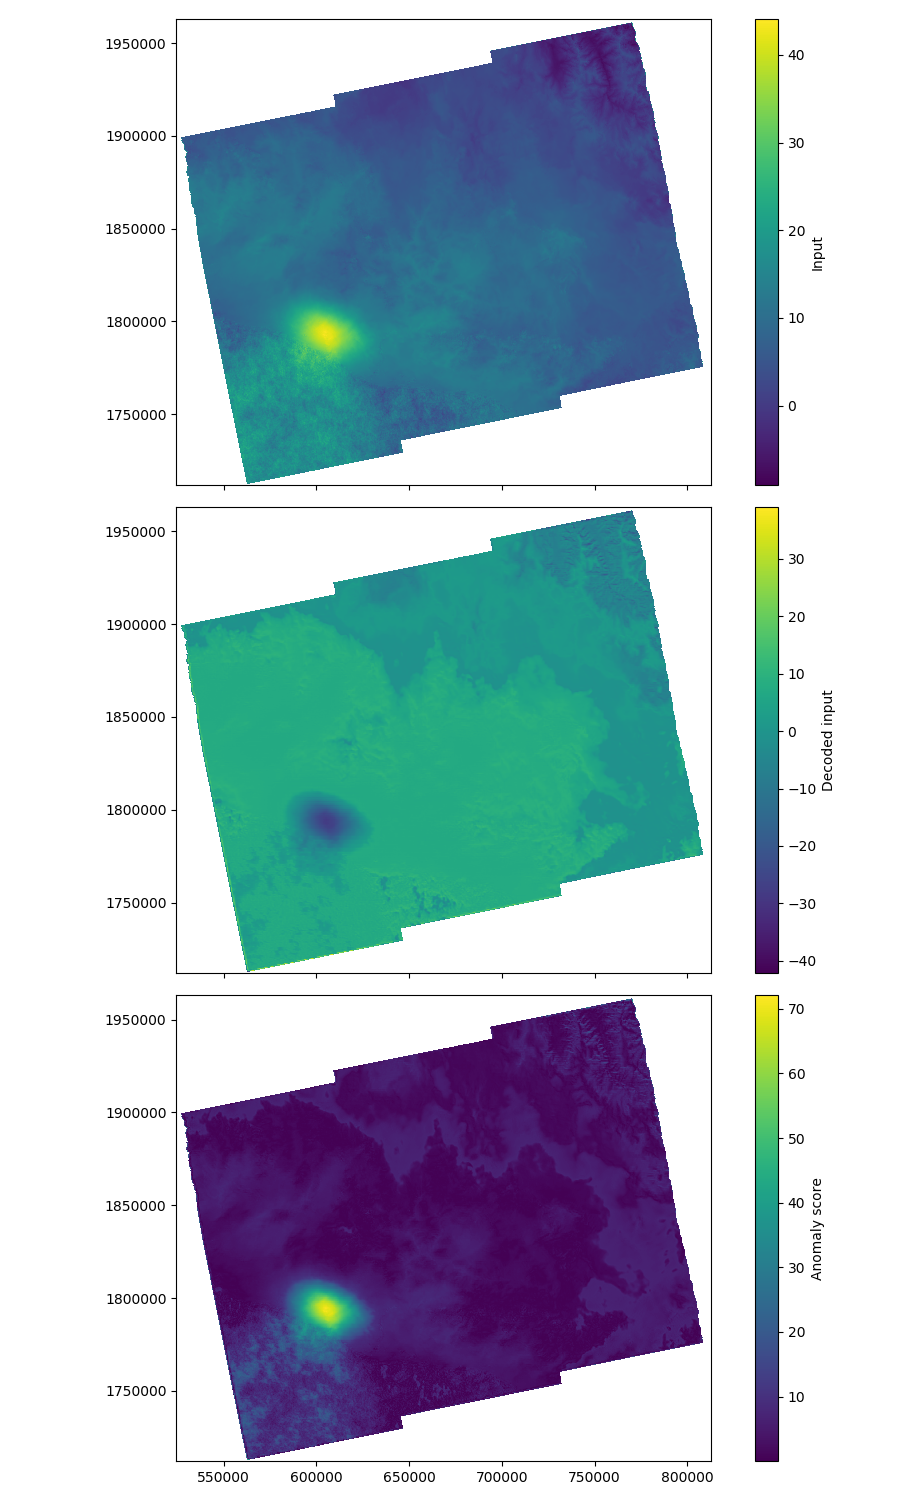

In [35]:
i_image = 10

figure, subplots = plt.subplots(nrows = 3, ncols = 1, sharex = True, sharey = False, figsize = (9, 15))

subplot = subplots[0]
image = subplot.imshow(np.ma.masked_invalid(application_data_array[index, i_image]), extent = application_data_extent,
                       cmap = 'viridis', interpolation = 'None', rasterized = True,
                       zorder = 0)
image_colorbar = plt.colorbar(image, ax = subplot)
image_colorbar.set_label('Input')

subplot = subplots[1]
image = subplot.imshow(np.ma.masked_invalid(prediction[i_image, ..., 0]), extent = application_data_extent,
                       cmap = 'viridis', interpolation = 'None', rasterized = True,
                       zorder = 0)
image_colorbar = plt.colorbar(image, ax = subplot)
image_colorbar.set_label('Decoded input')

subplot = subplots[2]
image = subplot.imshow(np.ma.masked_invalid(anomaly_scores[i_image]), extent = application_data_extent,
                       cmap = 'viridis', interpolation = 'None', rasterized = True,
                       zorder = 0)
image_colorbar = plt.colorbar(image, ax = subplot)
image_colorbar.set_label('Anomaly score')

plt.tight_layout()
                
plt.show()

In [32]:
suffix = 'topophase'
# suffix = 'atmtopophase'
georaster = create_georaster_from_array(anomaly_scores,           
                                        application_data_geotransform, 
                                        application_data_projection,
                                        file_type = 'GTiff',
                                        file_path = anomaly_folder + 'Stacked_Referenced_cae_anomaly_score_training_' + suffix + '_prediction_' + suffix + '.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None